# Training a Denoising Diffusion Probabilistic Model from Scratch

This notebook implements and trains a [**Denoising Diffusion Probabilistic Model (Ho et al., 2020)**](https://arxiv.org/abs/2006.11239).

For a technical introduction in image generation and diffusers, check my [blog post on that topic](https://mikelsagardia.io).

This notebook uses the co-located module [`unet.py`](unet.py), taken from [labmlai/annotated_deep_learning_paper_implementations](https://github.com/labmlai/annotated_deep_learning_paper_implementations). The entire dataset and model preparation, as well as the training, are contained in the present notebook. Some parts were modified from the course material of the [Udacity Generative AI Nanodegree](https://www.udacity.com/course/generative-ai--nd608).

I used an [NVIDIA RTX 3060](https://mikelsagardia.io/blog/mac-os-ubuntu-nvidia-egpu.html) during training (12GB VRAM).

Table of contents:

- [Setup](#setup)
- [Dataset](#dataset)
- [Forward Diffusion](#forward-diffusion)
- [*U-Net* Model](#u-net-model)
- [Training](#training)
  - [Auxiliary Functions](#auxiliary-functions)
  - [Run Training](#run-training)
  - [Load Best Model and Run Inference](#load-best-model-and-run-inference)

## Setup

In [1]:
import os
import random
import pathlib
from typing import Any, Optional, Callable
from dataclasses import dataclass
import multiprocessing

from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.optim import Optimizer, Adam
from torch.optim.lr_scheduler import LRScheduler, CosineAnnealingLR

# Local module where the UNet is defined
from unet import UNet

In [2]:
# Make results fully reproducible
seed = 42
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [3]:
# Name of each GPU
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))

0 NVIDIA GeForce RTX 3060
1 NVIDIA T500


In [4]:
# Check the GPU is ready
!nvidia-smi

Sat Nov 15 11:46:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T500                    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8            N/A  / 5001W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset

We are going to use the Stanford Cars dataset. It consists of 196 classes of cars with a total of 16185 images. However, we do not need any label, nor a test dataset. Additionally, we are going to resize the images to `64x64` for easier processing.

Note that the original dataset [https://ai.stanford.edu/~jkrause/cars/car_dataset.html](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) is not available anymore.
Instead, we can download it from Kaggle or HuggingFace.

- I downloaded it from [https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset](https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset) manually and unzipped it to `./data`. Unfortunately, the programmagtic `kagglehub` option didn't work for me.
- The alternative would be to download it from HuggingFace: [https://huggingface.co/datasets/tanganke/stanford_cars](https://huggingface.co/datasets/tanganke/stanford_cars); in that case, either the structure of the dataset or the code which instantiates the dataloaders need to be modified.

I have manually arranged this structure in `./data`:

```
data/
    stanford_cars/
        train/
            00001.jpg
            ...
        test/
            00001.jpg
            ...
        devkit/ (unused, since we don't need annotations)
            car_test_annos.mat
            car_train_annos.mat
            ...
```

This section builds a Pytorch Dataset & Dataloader based on the images.

In [ ]:
# Constants
IMG_SIZE = 64
BATCH_SIZE = 64  # 100
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class CarImagesDataset(Dataset):
    def __init__(
            self,
            root_dir: str | pathlib.Path,
            transform: Optional[transforms.Compose] = None
        ):
        self.transform = transform
        # Find all jpg files in the directory
        self.image_paths = list(pathlib.Path(root_dir).glob("*.jpg"))
        
    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
            
        return image, 0  # Return dummy label since we don't need it

In [7]:
def get_dataset(path: str | pathlib.Path) -> Dataset:
    data_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            # Flip horizontally with probability 50%
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # Scale data to [-1,1] 
            transforms.Normalize(0.5, 0.5)
        ]
    )
    
    # Use custom dataset for your flat folder structure
    train = CarImagesDataset(
        root_dir=pathlib.Path(path) / "train", 
        transform=data_transform
    )

    test = CarImagesDataset(
        root_dir=pathlib.Path(path) / "test", 
        transform=data_transform
    )
    
    return torch.utils.data.ConcatDataset([train, test])

In [ ]:
# Instantiate the dataset and dataloader
# using the previously defined function & class
data = get_dataset("./data/stanford_cars")
dataloader = DataLoader(
    data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    pin_memory=True,
    num_workers=multiprocessing.cpu_count(),
    persistent_workers=True
)

In [ ]:
# Convenience function to display a sequence of images
def display_sequence(imgs: torch.Tensor, dpi: int = 75, nrow: int = 8):    
    fig, sub = plt.subplots(dpi=dpi)
    sub.imshow(
        np.transpose(
            make_grid(
                imgs, 
                padding=0,
                normalize=True,
                nrow=nrow,
            ).cpu(),
            (1,2,0)
        )
    )
    _ = sub.axis("off")
    
    return fig

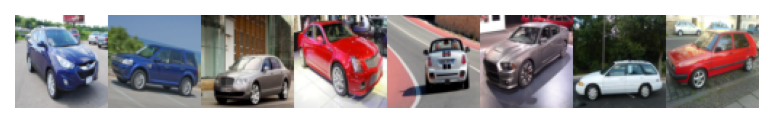

In [ ]:
# Get a batch
batch, _ = next(iter(dataloader))
# Display it (only the first 8 images)
_ = display_sequence(batch[:8], dpi=150)

## Forward Diffusion

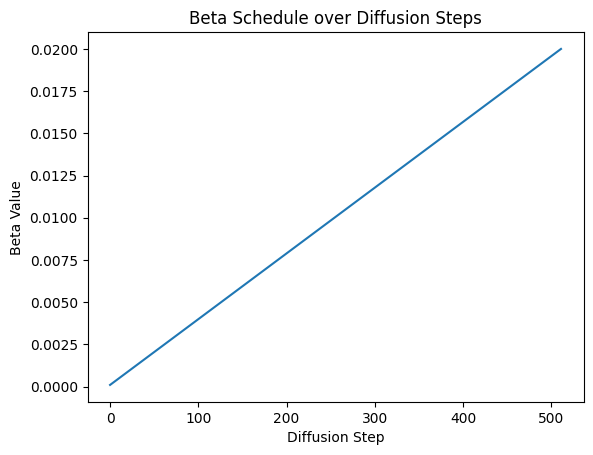

In [11]:
# Beta schedule
# Number of diffusion steps
T = 512
betas = torch.linspace(start=0.0001, end=0.02, steps=T)  # linear schedule

plt.plot(range(T), betas.numpy(), label='Beta Values')
plt.xlabel('Diffusion Step')
plt.ylabel('Beta Value')
_ = plt.title('Beta Schedule over Diffusion Steps')

**Formulae**:

Forward diffusion:

$x_t = q(x_t | x_{t-1}) = x_{t-1}\sqrt{1-\beta_t} + \epsilon_{t-1}\sqrt{\beta_t} = N(x_{t-1}\sqrt{1-\beta_t}, \beta_t I)$

$\epsilon_{t-1}\sqrt{\beta_t}$: noise map added during the forward/training phase

Reparametrization of the noise:

$\bar{\alpha_t} = \prod_{i=0}^{t}{\alpha_i} \prod_{i=0}^{t}{1 - \beta_i}$,

$x_t = q(x_t | x_0) = x_0\sqrt{\bar{\alpha_t}} + \epsilon\sqrt{1 - \bar{\alpha_t}} = N(x_0\sqrt{\bar{\alpha}_t}, (1-\bar{\alpha}_t) I)$

Reverse diffusion:

$x_{t-1} = p(x_{t-1} | x_t) = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_{\theta}) + \sigma_t z$

$z \sim N(0,I)$

$\sigma_t^2 = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t$

$\epsilon_{\theta}$: noise map predicted by the *UNet*


In [ ]:
@dataclass
class Config:
    img_size: int = IMG_SIZE
    batch_size: int = BATCH_SIZE
    T: int = 512
    beta_start: float = 0.0001
    beta_end: float = 0.02

    def __post_init__(self):
        # betas: linear schedule
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.T)
        # alphas
        self.alphas = 1.0 - self.betas
        # alpha bar
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        # alpha bar at t-1
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        # sqrt of alpha bar
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        # 1 / sqrt(alpha bar)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        # sqrt of one minus alpha bar
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        # sigma_t
        self.posterior_variance = (
            self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        )

    def to(self, device):
        for k, v in self.__dict__.items():
            if isinstance(v, torch.Tensor):
                setattr(self, k, v.to(device))
        return self

In [13]:
cfg = Config()

In [14]:
@torch.no_grad()
def visualize_forward_diffusion(
    image: torch.Tensor,
    config: Config,
    device: str | torch.device = "cpu",
    num_images: int = 16,
    dpi: int = 75,
    interleave: bool = False
) -> tuple:
    """
    Generate the forward sequence of noisy images taking the input image to pure noise.
    """
    imgs = []
    noises = []

    # Move to device
    config = config.to(device)
    image = image.to(device)

    # Visualize only num_images diffusion steps, instead of all of them
    stepsize = config.T // num_images
    for i in range(0, config.T, stepsize):
        t = torch.full((1,), i, device=device, dtype=torch.long)

        # Forward diffusion process
        bs = image.shape[0]
        noise = torch.randn_like(image, device=device)
        img = (
            config.sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * image + 
            config.sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
        )

        imgs.append(torch.clamp(img, -1, 1).squeeze(dim=0))
        noises.append(torch.clamp(noise, -1, 1).squeeze(dim=0))
    
    if interleave:
        imgs = [item for pair in zip(imgs, noises) for item in pair]
        
    fig = display_sequence(imgs, dpi=dpi)
    
    return fig, imgs[-1]

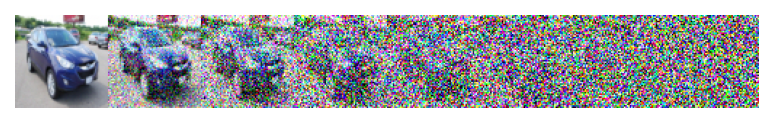

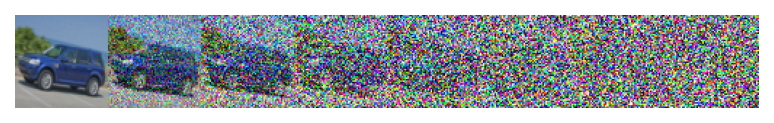

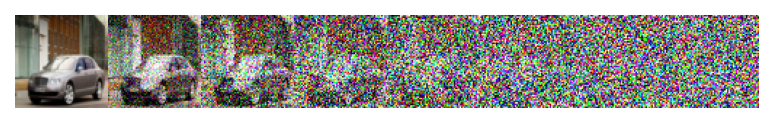

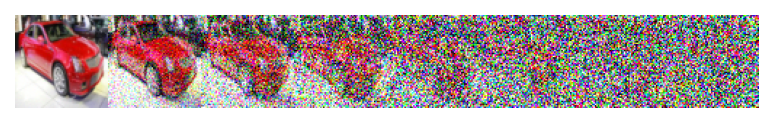

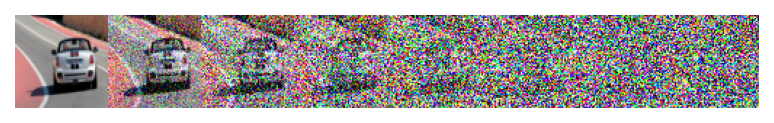

In [15]:
for image in batch[:5]:
    _ = visualize_forward_diffusion(
        image.unsqueeze(dim=0),
        cfg,
        num_images=7,
        dpi=150,
        interleave=False,
        device=DEVICE
    )

## *U-Net* Model

In [16]:
# model = UNet(ch_mults = (1, 2, 2, 2))  # Complex model for longer training
model = UNet(ch_mults = (1, 2, 1, 1))  # Simpler model for quicker testing

n_params = sum(p.numel() for p in model.parameters())
print(
    f"Number of parameters: {n_params:,}"
)
model = model.to(DEVICE)
cfg = cfg.to(DEVICE)


Number of parameters: 9,139,651


In [ ]:
@torch.no_grad()
def run_inference(
    input_noise: torch.Tensor,
    model: torch.nn.Module,
    config: Config,
    return_all: bool = False,
    device: str | torch.device = "cpu",
) -> torch.Tensor | list[torch.Tensor]:
    """
    Sample following the algorithm from the DDPM paper.
    """
    config = config.to(device)
    input_noise = input_noise.to(device)
    model = model.to(device)

    x = input_noise
    bs = x.shape[0]
    
    imgs = []
    
    for time_step in range(0, config.T)[::-1]:
        
        # This is the noise z that we will add back
        # into the denoised image (except if we are
        # at the very last iteration)
        noise = torch.randn_like(x) if time_step > 0 else 0
        
        # For each image in the batch we consider
        # the time step ts.
        # This creates a 1D tensor of shape (bs,)
        # all filled with value ts
        t = torch.full((bs,), time_step, device=device, dtype=torch.long)
        
        # This is the formula for the denoising
        # t is a tensor of size (bs,),
        # i.e., we are picking the timestep t for all
        # images in the batch
        # Recall: alpha[t] = 1 - beta[t]
        x = config.sqrt_recip_alphas[t].view(bs, 1, 1, 1) * (
            x - config.betas[t].view(bs, 1, 1, 1) * model(x, t) / 
            config.sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1)
        ) + torch.sqrt(config.posterior_variance[t].view(bs, 1, 1, 1)) * noise
        
        # Cut every value below -1 or above 1
        # (this is needed for the conversion back to RGB
        # image to work well)
        # Later the [-1,1] range will be mapped to [0,255]
        imgs.append(torch.clamp(x, -1, 1))
    
    if return_all:
        return imgs
    else:
        return imgs[-1] 

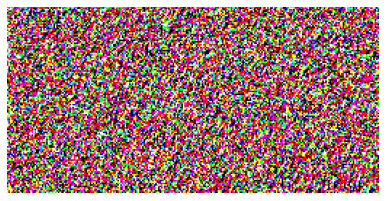

In [18]:
input_noise = torch.randn((8, 3, IMG_SIZE, IMG_SIZE), device=DEVICE)
imgs = run_inference(input_noise, model, cfg, device=DEVICE)
_ = display_sequence(imgs, dpi=75, nrow=4)

In [ ]:
# Clean up memory actively
# A new model is instantiated below for training
del model

## Training

### Auxiliary Functions

In [21]:
def save_model(
    model: torch.nn.Module,
    path: str | pathlib.Path,
    optimizer: Optional[torch.optim.Optimizer] = None,
    scheduler: Optional[Any] = None,
    epoch: Optional[int] = None,
    cfg: Optional[Any] = None,
    ema_loss: Optional[float] = None,
    **extra,
) -> None:
    """
    Save model checkpoint with optional training components.
    """

    path = pathlib.Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    checkpoint = {
        "model_state_dict": model.state_dict(),
    }

    if optimizer:
        checkpoint["optimizer_state_dict"] = optimizer.state_dict()
    if scheduler:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()
    if cfg:
        checkpoint["config"] = cfg.__dict__
    if epoch is not None:
        checkpoint["epoch"] = epoch
    if ema_loss is not None:
        checkpoint["ema_loss"] = ema_loss

    # Append extra metadata
    checkpoint.update(extra)

    torch.save(checkpoint, path)


In [22]:
def load_model(
    model: torch.nn.Module,
    path: str | pathlib.Path,
    optimizer: Optional[torch.optim.Optimizer] = None,
    scheduler: Optional[Any] = None,
    map_location: str | torch.device = "cpu",
) -> dict[str, Any]:
    """
    Load model + optional optimizer/scheduler state.
    Returns the full checkpoint dictionary so the caller 
    can inspect metadata like epoch, ema_loss, etc.
    """
    checkpoint = torch.load(path, map_location=map_location)

    # Restore model
    model.load_state_dict(checkpoint["model_state_dict"])

    # Restore optimizer
    if optimizer and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    # Restore scheduler
    if scheduler and "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    return checkpoint

In [ ]:
def sample_fn(
    model: torch.nn.Module,
    fixed_noise: torch.Tensor,
    config: Config,
    device: str | torch.device,
) -> plt.Figure:
    model.eval()
    with torch.no_grad():
        # If the fixed_noise is (1, 3, 64, 64)
        # We get a list of len(config.T) = 512 containing
        # tensors of shape (1, 3, 64, 64)
        imgs = run_inference(
            fixed_noise,
            model,
            config,
            return_all=True,
            device=device,
        )
    if isinstance(imgs, torch.Tensor):
        imgs = imgs.cpu()
    else:
        imgs = [img.cpu() for img in imgs]
    fig = display_sequence(
        # If T=512, we take the first + every 64th to get 9 images in total
        # equally spaced through the diffusion process
        [imgs[0].squeeze(dim=0)] + [x.squeeze(dim=0) for x in imgs[63::64]],
        nrow=9,
        dpi=150,
    )
    return fig

In [ ]:
def train(
    model: torch.nn.Module,
    dataloader: DataLoader,
    cfg: Config,
    optimizer: Optimizer,
    scheduler: Optional[LRScheduler],
    device: str | torch.device,
    epochs: int,
    warmup_epochs: int,
    base_lr: float,
    criterion: Optional[torch.nn.Module] = None,
    output_dir: str | pathlib.Path = "diffusion_output",
    alpha: float = 0.1,  # EMA smoothing factor
    fixed_noise: Optional[torch.Tensor] = None,
    sample_fn: Optional[
        Callable[[torch.nn.Module, torch.Tensor, Config, torch.device], plt.Figure]
    ] = None,
) -> dict[str, Any]:
    """
    Train a diffusion model.

    Args:
        model: UNet (or compatible) model.
        dataloader: Training dataloader.
        cfg: Config instance with diffusion schedule.
        optimizer: Optimizer (e.g., Adam).
        scheduler: LR scheduler (e.g., CosineAnnealingLR) or None.
        device: Torch device.
        epochs: Total number of epochs.
        warmup_epochs: Number of warmup epochs (linear LR warmup).
        base_lr: Target maximum LR after warmup.
        criterion: Loss function. If None, MSELoss is used.
        output_dir: Directory where checkpoints & samples are saved.
        alpha: EMA factor for the loss.
        fixed_noise: Optional noise tensor for sampling images.
        sample_fn: Optional function: (model, fixed_noise, device) -> matplotlib Figure.

    Returns:
        history: dict with lists per epoch, e.g.:
            {
                "loss": [...],
                "ema_loss": [...],
                "lr": [...],
            }
    """
    output_dir = pathlib.Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    samples_dir = output_dir / "samples"
    samples_dir.mkdir(parents=True, exist_ok=True)
    ckpt_dir = output_dir / "checkpoints"
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    model.to(device)
    cfg.to(device)

    if criterion is None:
        criterion = torch.nn.MSELoss()

    if fixed_noise is None:
        fixed_noise = torch.randn(
            (1, 3, cfg.img_size, cfg.img_size), device=device
        )

    history: dict[str, Any] = {"loss": [], "ema_loss": [], "lr": []}
    ema_loss: Optional[float] = None
    best_ema_loss = float("inf")

    for epoch in range(epochs):
        model.train()

        # LR warmup / scheduling
        if epoch < warmup_epochs:
            lr = base_lr * float(epoch + 1) / float(warmup_epochs)
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
        else:
            if scheduler is not None:
                scheduler.step()
            lr = optimizer.param_groups[0]["lr"]

        current_lr = lr

        running_loss = 0.0
        num_batches = 0

        for batch, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            batch = batch.to(device)
            bs = batch.shape[0]

            optimizer.zero_grad()

            # Sample timesteps
            # Random time steps, one for each image in the mini-batch
            # It is important to pick several time stamp
            # We want to compute the _expectaction_ of the MSE
            # so the sampling across different time steps is essential
            t = torch.randint(0, cfg.T, (bs,), device=device).long()

            # Add noise according to forward process q(x_t | x_0)
            # Torch can generate normally distributed number in N(0,1)
            # so we need to shift them to N(sqrt(alpha_bar_t)*x_0, (1-alpha_bat_t)*I):
            # N(sqrt(alpha_bar_t)*x_0, (1-alpha_bat_t)*I) = 
            # sqrt(alpha_bar_t)*x_0 + sqrt(1-alpha_bat_t) * N(0,1)
            noise = torch.randn_like(batch, device=device)
            x_noisy = (
                cfg.sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * batch
                + cfg.sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
            )

            # Predict the noise
            # NOTE how the model receives in input the noisy
            # image AND the time step t
            noise_pred = model(x_noisy, t)

            # Loss computation
            # Approximate taking the expectation by averaging
            # the MSE loss over the minibatch and the random time steps
            # By selecting a sufficiently large batch size
            # and by picking random time steps t
            # we are approximating the process of computing the expectation
            # of the MSE across all time steps
            loss = criterion(noise, noise_pred)
            loss.backward()
            optimizer.step()

            loss_val = float(loss.item())
            running_loss += loss_val
            num_batches += 1

            # EMA loss
            if ema_loss is None:
                ema_loss = loss_val
            else:
                ema_loss = alpha * loss_val + (1.0 - alpha) * ema_loss

        epoch_loss = running_loss / max(num_batches, 1)
        epoch_ema_loss = float(ema_loss) if ema_loss is not None else epoch_loss

        history["loss"].append(epoch_loss)
        history["ema_loss"].append(epoch_ema_loss)
        history["lr"].append(current_lr)

        # Save checkpoint for this epoch
        ckpt_path = ckpt_dir / f"last_model.pt"
        save_model(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch+1,
            cfg=cfg,
            ema_loss=epoch_ema_loss,
            path=ckpt_path,
        )

        # Track & save best model
        if epoch_ema_loss < best_ema_loss:
            best_ema_loss = epoch_ema_loss
            best_model_path = ckpt_dir / "best_model.pt"
            save_model(
                model=model,
                path=best_model_path,
                ema_loss=epoch_ema_loss,
                epoch=epoch+1,
                cfg=cfg,
            )

        # Optional: generate & save sample images
        if sample_fn is not None and fixed_noise is not None:
            model.eval()
            with torch.no_grad():
                fig = sample_fn(model, fixed_noise, cfg, device)
            sample_path = samples_dir / f"sample_epoch_{epoch+1:03d}.png"
            fig.savefig(sample_path, dpi=150, bbox_inches="tight")
            plt.close(fig)

        print(
            f"Epoch {epoch+1}/{epochs}: "
            f"loss={epoch_loss:.4f}, ema_loss={epoch_ema_loss:.4f}, lr={current_lr:.6f}"
        )

    return history

### Run Training

In [25]:
from unet import UNet

# Configuration
cfg = Config()

model = UNet(ch_mults = (1, 2, 2, 2))  # Complex model for longer training
#model = UNet(ch_mults = (1, 2, 1, 1))  # Simpler model for quicker testing

n_params = sum(p.numel() for p in model.parameters())
print(
    f"Number of parameters: {n_params:,}"
)

# Parameters for training: SHORTER TRAINING SETTINGS
#base_lr = 0.0006  # Maximum learning rate we will use
#epochs = 10  # Total number of epochs
#warmup_epochs = 2  # Number of warm-up epochs (cosine annealing will be done after this)

# Parameters for training: LONGER TRAINING SETTINGS
base_lr = 0.0001  # Maximum learning rate we will use
epochs = 300  # Total number of epochs
warmup_epochs = 10  # Number of warm-up epochs

Number of parameters: 54,563,779


In [26]:
# Optimizer and scheduler
optimizer = Adam(model.parameters(), lr=base_lr)
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=epochs - warmup_epochs,
    eta_min=base_lr / 10,
)

In [ ]:
# Train the model!
history = train(
    model=model,
    dataloader=dataloader,
    cfg=cfg,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    epochs=epochs,
    warmup_epochs=warmup_epochs,
    base_lr=base_lr,
    output_dir="output",
    alpha=0.1,
    fixed_noise=torch.randn((1, 3, cfg.img_size, cfg.img_size), device=DEVICE),
    sample_fn=sample_fn,
)

### Learning Curves

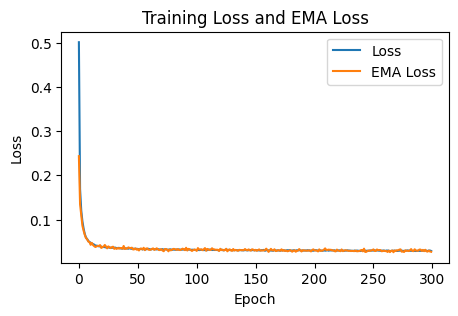

In [33]:
plt.figure(figsize=(5, 3))
plt.plot(history["loss"], label="Loss")
plt.plot(history["ema_loss"], label="EMA Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss and EMA Loss")
plt.legend()
plt.show()

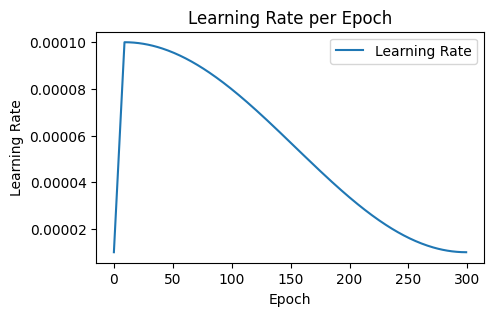

: 

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(history["lr"], label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate per Epoch")
plt.legend()
plt.show()

### Load Best Model and Run Inference

In [28]:
# Load the best model
# Weights are loaded into the existing 'model' instance
ckpt = load_model(
    model,
    path="output/checkpoints/best_model.pt",
)

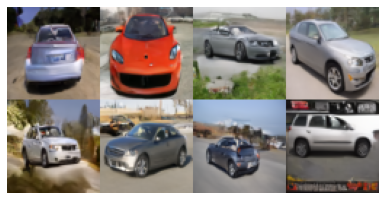

In [29]:
# Run inference with the trained model
input_noise = torch.randn((8, 3, IMG_SIZE, IMG_SIZE), device=DEVICE)
imgs = run_inference(input_noise, model, cfg, device=DEVICE)
_ = display_sequence(imgs, dpi=75, nrow=4)